# Part II - The Determinants of Borrower Interest Rate and Loan Amount From Prosper Loan Data
## by _Godwin Akpa_

## Investigation Overview
> Prosper Loan Services is a money lending (thrift) business based in the United States of America that bridges the gap between those who need money, the Borrowers and those who have money to lend, the Investors. In this investigation or analysis, I tried to ascetain the main determinants of borrowers interest rate and  loan amount from various independent variables such as Prosper Score, Original loan amount, Monthly Income, Income Range, and Employment Status. The main focus was on several borrowers information, such as original loan amount, loan term, borrower's stated monthly income, Occupation, interest rate (BorrowerAPR, BorrowerRate) and most importantly, rating (Prosper Rating). 

## Dataset Overview
> The Prosper loan dataset comprises of 113937 loan entries with 81 attributes on each loan, from the year 2009-2014. There are two main categories of the attributes:
>- **Borrower information:** Basic attributes of the borrowers such as annual income, condition of employment, interest rate, loan status, etc.
>- **Historical loan performance Metrics:** Metrics evaluating the risk associated with the loans such as Prosper score, Prosper rating and Borrower APR, etc. Nevertheless, there were some elements that I needed to fix, in order to create interesting and trustworthy analyses and visualizations.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loan = pd.read_csv('prosperloandata.csv')

In [3]:
# Define features of interest for this analysis
columns = ['ListingNumber', 'ListingCreationDate', 'ProsperRating (Alpha)', 'Occupation', 'ProsperScore', 'ListingCategory (numeric)', 
           'EmploymentStatus', 'IsBorrowerHomeowner', 'CurrentCreditLines', 'DebtToIncomeRatio', 'LoanOriginalAmount', 'LoanStatus', 
           'BorrowerState', 'IncomeRange','BorrowerAPR','BorrowerRate', 'StatedMonthlyIncome', 'Investors','Term']
# New subdataset
loan = loan[columns]

In [4]:
# Drop duplicate values
loan_df = loan.drop_duplicates(subset=['ListingNumber','ListingCreationDate'], keep='first')

In [5]:
# Because this is a thrift system, customers rating (ProsperRating) is the most important feature of this dataset
# thus I will select only not null rows 
loan_df = loan_df[loan_df['ProsperRating (Alpha)'].notnull()]

In [6]:
# Filling missing values with mean
loan_df['DebtToIncomeRatio']=loan_df['DebtToIncomeRatio'].fillna(loan_df['DebtToIncomeRatio'].mean())

In [7]:
# Filling missing values 
loan_df['Occupation']=loan_df['Occupation'].fillna('Unknown')

In [8]:
# Rename columns
loan_df.rename(columns = {'ProsperRating (Alpha)': 'ProsperRating', 'ListingCategory (numeric)': 'ListingCategory', 
                          'IsBorrowerHomeowner': 'Collateral'}, inplace=True)

In [9]:
# Convert 'ListingCreationDate' type from str to datetime 
loan_df['ListingCreationDate']=pd.to_datetime(loan_df['ListingCreationDate'])

# Convert 'ListingNumber' type from int to string 
loan_df['ListingNumber']=loan_df['ListingNumber'].astype(str)

# Convert 'ListingNumber' type from float to int
loan_df['ProsperScore']=loan_df['ProsperScore'].astype(int)

In [10]:
# Extract date information from ListingCreationDate column
loan_df['Date'] = loan_df['ListingCreationDate'].dt.date

# Extract year information from ListingCreationDate column
loan_df['Year']= loan_df['ListingCreationDate'].dt.year

In [11]:
# Convert 'date' type from str to datetime 
loan_df['Date']=pd.to_datetime(loan_df['Date'])

# Convert 'ListingCategory' type  to str
loan_df['ListingCategory']=loan_df['ListingCategory'].astype(str)

# Drop the ListingCreationDate column
loan_df.drop(['ListingCreationDate'], axis=1)

ListingNumber ProsperRating               Occupation  ProsperScore  \
1            1209647             A             Professional             7   
3             658116             A            Skilled Labor             9   
4             909464             D                Executive             4   
5            1074836             B             Professional            10   
6             750899             E           Sales - Retail             2   
7             768193             C                  Laborer             4   
8            1023355            AA             Food Service             9   
10            587746             C                  Fireman             7   
12           1081604             B           Sales - Retail             4   
13            840820             A             Construction             8   
14            757359             A      Computer Programmer             8   
15            577164            HR                    Other             5   
16            841846             E             Professional             4   
18            716058             A       Sales - Commission             7   
19            875565             D                  Laborer             8   
20           1011916             B        Retail Management             7   
22            706927            HR                    Other             2   
23            758964             D            Skilled Labor             5   
24           1046345             C                    Other             5   
25            950067             E    Engineer - Mechanical             3   
26            713131             E       Sales - Commission             3   
27            463083             A                Executive             9   
28            989519             C        Military Enlisted             4   
29           1051243             A                    Other             6   
30            555213             A                    Other             9   
31            643927            HR                    Other             5   
32           1132356             B                 Clerical             8   
33            478891            AA                    Other            10   
34           1180690             C                  Unknown             5   
35            544093             B        Retail Management             8   
...              ...           ...                      ...           ...   
113894        438537            AA                 Investor            10   
113895        990985             C    Engineer - Mechanical             7   
113898        451665             B           Sales - Retail             8   
113899        449436             A        Military Enlisted             8   
113900       1214162             B           Accountant/CPA             6   
113901       1011976             B                Executive             8   
113903       1182559             C              Landscaping             4   
113905        539189            HR                    Other             2   
113907       1005215            HR           Sales - Retail             2   
113908        486057             E       Sales - Commission             5   
113909        635880             C                 Clerical             7   
113910       1161059             E                Executive             2   
113911        996496             D                    Other             3   
113912       1083677            AA                Scientist            11   
113913        455673             A                  Analyst             9   
113916        667047             E             Professional             6   
113917       1028126             E                 Clerical             2   
113919        772509             D                    Other             3   
113920        804763            HR        Retail Management             2   
113924        657862             A                    Other             8   
113

In [12]:
# Aggregate Past Due loans 
loan_df['LoanStatus'] = loan_df['LoanStatus'].apply(lambda x: x if 'Past Due' not in x else 'Past Due')

# convert 'LoanStatus' from string to ordinal category type
loan_level = ['Defaulted', 'Chargedoff', 'Past Due' , 'Current', 'FinalPaymentInProgress', 'Completed']
ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = loan_level)
loan_df['LoanStatus'] = loan_df['LoanStatus'].astype(ordered_var)


In [13]:
# replace numerical values for Term with proper names
term_dict = {12 : 'Short', 36 : 'Medium', 60 : 'Long'}
loan_df['Term'] = loan_df['Term'].map(term_dict)

# convert Term from int to ordinal category type
term_cat = ['Short', 'Medium', 'Long']
term_var = pd.api.types.CategoricalDtype(ordered = True, categories = term_cat)
loan_df['Term'] = loan_df['Term'].astype(term_var)

In [14]:
# convert 'IncomeRange' from string to ordinal category type
income_range = ['Not employed', '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999',  '$100,000+']
income_range_var = pd.api.types.CategoricalDtype(ordered = True, categories = income_range)
loan_df['IncomeRange'] = loan_df['IncomeRange'].astype(income_range_var)

In [15]:
# replace Listing Categories with readable strings as listing names according to the data dictionary
loan_df['ListingCategory'] = loan_df['ListingCategory'].replace(['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'], 
                                           ['Not Available','Debt Consolidation','Home Improvement','Business','Personal Loan','Student Use','Auto','Other',
                                             'Baby&Adoption','Boat','Cosmetic Procedure','Engagement Ring','Green Loans','Household Expenses',
                                             'Large Purchases','Medical/Dental','Motorcycle','RV','Taxes','Vacation','Wedding Loans'])

In [16]:
# convert 'ProsperRating Alpha' from string to ordinal category type
rating = ['HR', 'E', 'D', 'C', 'B', 'A', 'AA']
prosper_rating = pd.api.types.CategoricalDtype(ordered = True, categories = rating)
loan_df['ProsperRating'] = loan_df['ProsperRating'].astype(prosper_rating)

# convert 'EmploymentStatus' from string to ordinal category type
emp_level = ['Not employed', 'Other', 'Retired','Part-time', 'Full-time', 'Employed', 'Self-employed']
ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = emp_level)
loan_df['EmploymentStatus'] = loan_df['EmploymentStatus'].astype(ordered_var)

In [17]:
# define a classification function
def classify(record):
    if record["StatedMonthlyIncome"]<3000:
        return 'Low Income'
    if record["StatedMonthlyIncome"]<20000:
        return 'Medium Income'
    else:
        return 'High Income'
    
loan_df['IncomeGroup'] = loan_df.apply(classify, axis=1)

# convert string to ordinal category type
ordinal_class = ['Low Income', 'Medium Income', 'High Income']
ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_class)
loan_df['IncomeGroup'] = loan_df['IncomeGroup'].astype(ordered_var)

## Prosper's Borrowers Risk Analysis
> Prosper Score was built using historical Prosper data. The score ranges from 1 to 11, with 11 being best or lowest risk score, and 1 being the worst or highest risk score.
> This plot shows that the three most earned Prosper scores are 4, 6, and 8 which shows a well distributed credit risks.

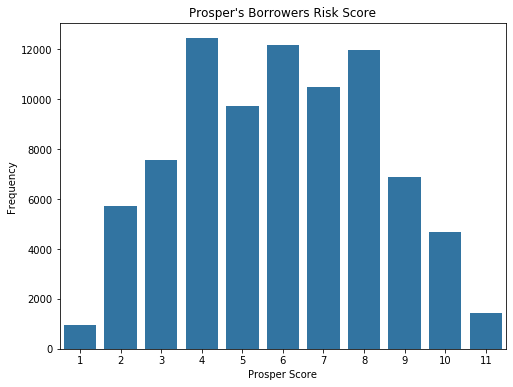

In [18]:
# Resize the chart
plt.figure(figsize=[8,6])

#color label
base_color = sb.color_palette()[0]
# Sort in Order (Using the order argument) 
#status_order = loan_df.ProsperScore.value_counts().index

#Plot ordinal variable distribution 'ProsperScore'
sb.countplot(data=loan_df, x='ProsperScore', color=base_color);
plt.xlabel("Prosper Score")
plt.ylabel('Frequency')
plt.title("Prosper's Borrowers Risk Score");
locs, labels = plt.xticks()
cat_counts = loan_df['ProsperScore'].value_counts()

## Evaluation of ProsperRating, EmploymentStatus and LoanStatus
> We can see that most borrowers have a good standing with Prosper majority of which have C Rating. While ratings B, A & D makes up for the other three highest Rating. Meanwhile the lowest Credit Rating is the AA Prosper Rating(with less than 10%).
> The majority of borrowers are employed, which is evident because it wouldn't be easy to get a loan without a job.
> More than 80% of all borrowers for the Prosper loans have good profiles, i.e either current or completed (good profiles) with more than 50% of this being current.

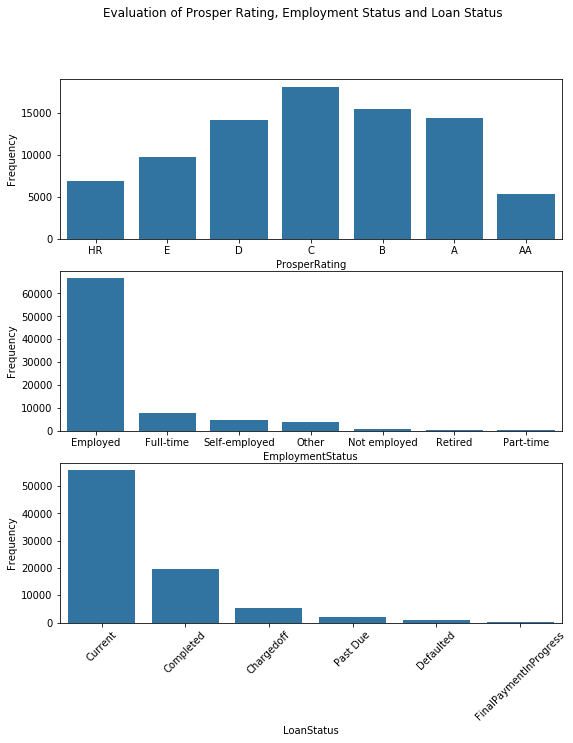

In [40]:
# let's plot all three together to get an idea of each ordinal variable's distribution.

fig, ax = plt.subplots(nrows=3, figsize = [9,10])

# Sort in Order (Using the order argument) 
emp_order = loan_df.EmploymentStatus.value_counts().index
loan_order = loan_df.LoanStatus.value_counts().index
# plotting ProsperRating, EmploymentStatus and LoanStatus together
sb.countplot(data = loan_df, x = 'ProsperRating', color = base_color, ax = ax[0])
sb.countplot(data = loan_df, x = 'EmploymentStatus', order=emp_order, color = base_color, ax = ax[1])
sb.countplot(data = loan_df, x = 'LoanStatus', order=loan_order, color = base_color, ax = ax[2])
ax[0].set_ylabel("Frequency")
ax[1].set_ylabel("Frequency")
ax[2].set_ylabel("Frequency")
plt.xticks(rotation=45)
fig.suptitle('Evaluation of Prosper Rating, Employment Status and Loan Status')
plt.show();

## Debt to Income Ratio
> Generally, higher DebtToIncomeRatio demonstrates that a customer has too much debt for the amount of income. On the other hand, lower DebtToIncomeRatio means a good balance between debt and income.

>- It appears from the figure above that most borrowers who applied for a loan have a debt to income ratio around 20% -30%

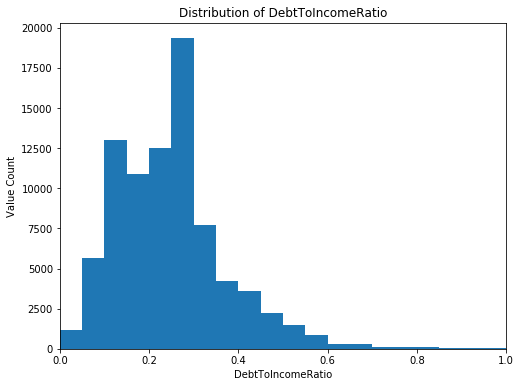

In [32]:
 # Resize the chart
plt.figure(figsize=[8,6])
# Plot DebtToIncomeRatio
binsize = 0.05
bins = np.arange(0, loan_df['DebtToIncomeRatio'].max()+binsize, binsize)
plt.hist(data = loan_df, x = 'DebtToIncomeRatio', bins = bins, color=base_color)
plt.xlabel('DebtToIncomeRatio')
plt.ylabel('Value Count')
plt.title('Distribution of DebtToIncomeRatio')
plt.xlim(0,1);

## Investors Analysis
> The Investor plot has a long-tailed distribution, with a lot of details on the low investor end, and few on the high investor end. When plotted on a log-scale, the investors distribution took an obvious normal distribution between 10 and 100 and  looks somewhat bimodal, with one high peak between 1 and 2, and a second peak a little below 100.
> The high peak at 1 implies that most of the loans were singly-funded (had single investors).

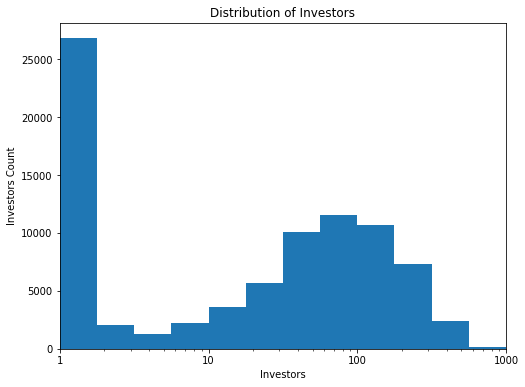

In [33]:
# Resize the chart
plt.figure(figsize=[8,6])
# plot the loan original amount against a log scale because it has a long tail
log_binsize = 0.25
bins_log = 10 ** np.arange(0, 3.1+log_binsize, log_binsize)
plt.hist(data = loan_df, x = 'Investors', bins = bins_log, color=base_color)
plt.xscale('log')
x_ticks = [0, 1, 10, 100, 1000]
x_ticks_names = [0, 1, 10, 100, 1000]
plt.xticks(x_ticks, x_ticks_names)
plt.xlim(1,1000)
plt.xlabel('Investors')
plt.ylabel('Investors Count')
plt.title('Distribution of Investors');


## Distribution of Term
> We have short term loans: 1 year, Medium term loans: 3 years and long term: 5 years. The most common type is the medium term loan followed by 5 year loan. Meanwhile, the short term loan is very rare.

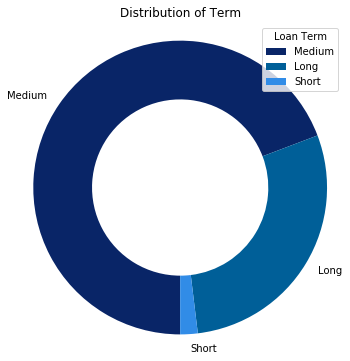

In [103]:
# Plot the new variable
plt.figure(figsize=(8,6))
# Plot Term
term_sorted = loan_df.Term.value_counts()
plt.pie(term_sorted, labels=term_sorted.index, colors= ['#092567', '#005F98', '#318CE7'], 
        startangle=270, counterclock=False, wedgeprops={'width': 0.4})
plt.axis('Square')
plt.title('Distribution of Term')
plt.legend(title="Loan Term");

## Evaluation of Borrower State, Occupation and Listing Category
>- The top 5 borrowers states are Illinois, Florida, Texas, New York and California
>- The topmost distinct occupation of Prosper borrowers are Teacher, Computer Programmer, Executives, Professional among others.
>- Majority of the loans was taken to be utilized for Auto, Business, Home Improvement as well as for Debt Consolidation.

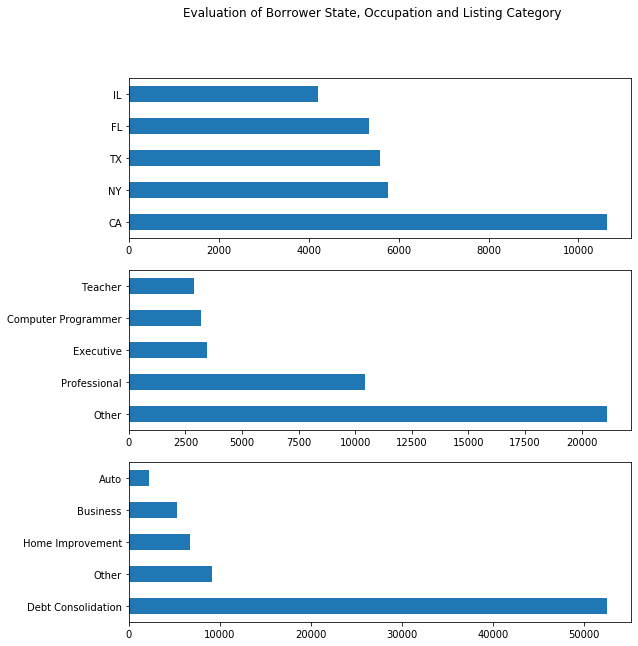

In [39]:
# let's plot all three together to get an idea of each ordinal variable's distribution.

fig, ax = plt.subplots(nrows=3, figsize = [9,10])

# plotting ProsperRating, EmploymentStatus and LoanStatus together
loan_df.BorrowerState.value_counts()[:5].plot(kind='barh', color = base_color, ax = ax[0])
loan_df.Occupation.value_counts()[:5].plot(kind='barh', color = base_color, ax = ax[1])
loan_df.ListingCategory.value_counts()[:5].plot(kind='barh', color = base_color, ax = ax[2])
fig.suptitle('Evaluation of Borrower State, Occupation and Listing Category')
plt.show();

## Income Group
> The majority of people who have taken out credit are the medium income earners and have an average monthly salary between 3,000 dollars and 20,000 dollars.

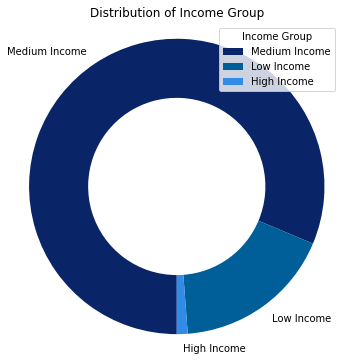

In [105]:
# Plot the new variable
plt.figure(figsize=(8,6))

# Plot Income Group
loan_sorted = loan_df.IncomeGroup.value_counts()
plt.pie(loan_sorted, labels=loan_sorted.index, colors= ['#092567', '#005F98', '#318CE7'], 
        startangle=270, counterclock=False, wedgeprops={'width': 0.4})
plt.axis('Square')
plt.title('Distribution of Income Group')
plt.legend(title="Income Group");

## Relationship between Prosper Score and Investors
> The trend line suggests a slight upward trend in investors over prosper score. This implies the investors bias and preference to invest in borrowers with higher prosper score

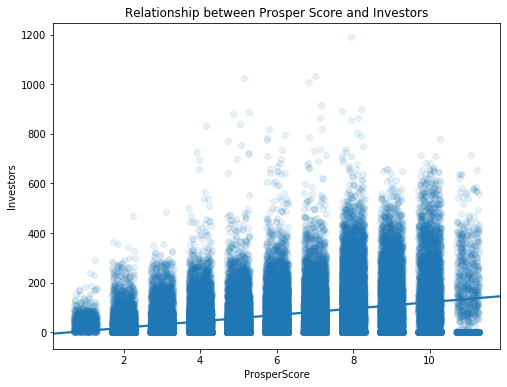

In [106]:
#Resize the plot
plt.figure(figsize=(8,6))
#plot scatterplot
sb.regplot(data=loan_df, x='ProsperScore', y='Investors', x_jitter=0.3, scatter_kws={'alpha':1/10})
plt.title('Relationship between Prosper Score and Investors');

## Relationship between BorrowerAPR and Original Loan Amount
> The relationship between BorrowerAPR and LoanOriginalAmount shows that smaller rates are given to borrowers with high loan original amount.

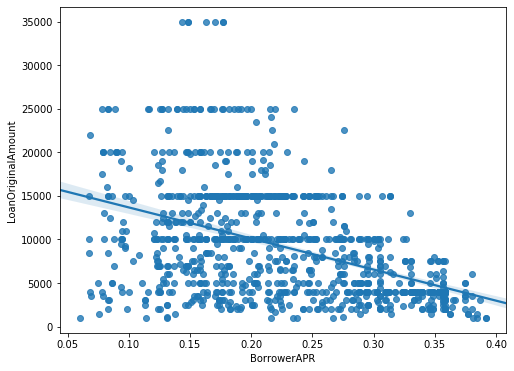

In [107]:
#Resize the plot
plt.figure(figsize=(8,6))
#plot scatterplot
loan_samp = loan_df.sample(n=1000, replace=False)
sb.regplot(data=loan_samp, x='BorrowerAPR', y='LoanOriginalAmount')
plt.title('Relationship between Prosper Score and Investors');;

## Relationship between Loan Term, Prosper Rating and Income Group
> **Loan Term**
>- We can see clearly that Short term loans has the closest ration between all wage groups, while the long term loans has the most distinct ratio.
>- Across all the loan terms, medium income earners made the most loan request.
>- Also, most customers prefer medium term loans.

> **Investors**
>- Borrowers with good Prosper Ratings tend to have many investors contribute to their loan amount than those with poor ratings. Similarly, borrowers with good Prosper Rating tend to be in the high income group.

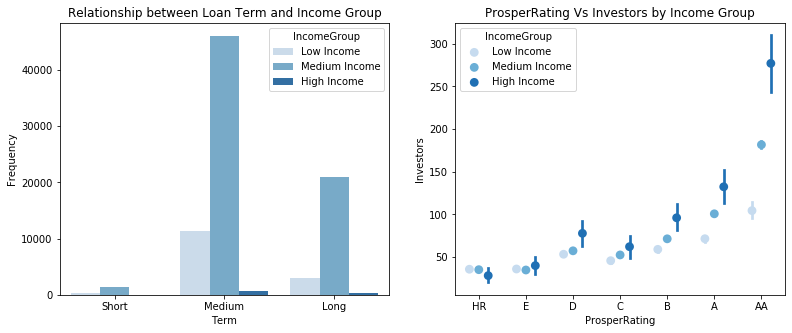

In [43]:
fig, ax = plt.subplots(ncols = 2, figsize = [13,5])
# plot the lineplot to analyze homeowner's and non-homeowner's rate over the years

#plot countplot 
g = sb.countplot(data=loan_df, x='Term', hue='IncomeGroup', palette='Blues', ax = ax[0])
ax[0].set_title('Relationship between Loan Term and Income Group')
ax[0].set_ylabel('Frequency')

# plot the pointplot
g = sb.pointplot(data = loan_df, x = 'ProsperRating', y = 'Investors', hue = 'IncomeGroup',
                  palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[1])
ax[1].set_title('ProsperRating Vs Investors by Income Group')
ax[1].set_ylabel('Investors')
plt.show();

## Relationship between ProsperRating and IncomeRange
> Except for AA (with income range 100,000 dollarsand above), all the borrowers regardless of their prosper rating has an income range between 25,000 dollars and 74,999 dollars which further buttresses the fact that medium income earners requested for most loans from Prosper.

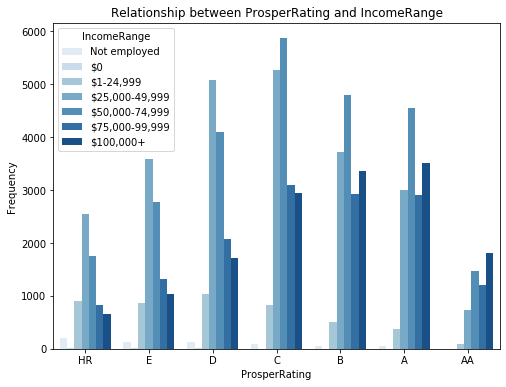

In [45]:
plt.figure(figsize=(8,6))
#plot countplot 
sb.countplot(data=loan_df, x='ProsperRating', hue='IncomeRange', palette='Blues')
plt.title('Relationship between ProsperRating and IncomeRange')
plt.ylabel('Frequency');

## Relationship between Borrower Rate, ProsperScore and Term, Collateral, IncomeGroup
> It appears that there are some negative relationships between the categorical/ordinal variables selected and the interest rate.

>- Its worthy of note that, more restrictive credit condition (higher rate) is applied to Medium and Long term loans than the short term loans.
>- Another observation is that borrowers who have collaterals(homeowners) and higher income have lower rates than those with Low Income or who don't have any collateral .
>- Meanwhile, short term loans, having collateral and higher income promotes a high Prosper Score.

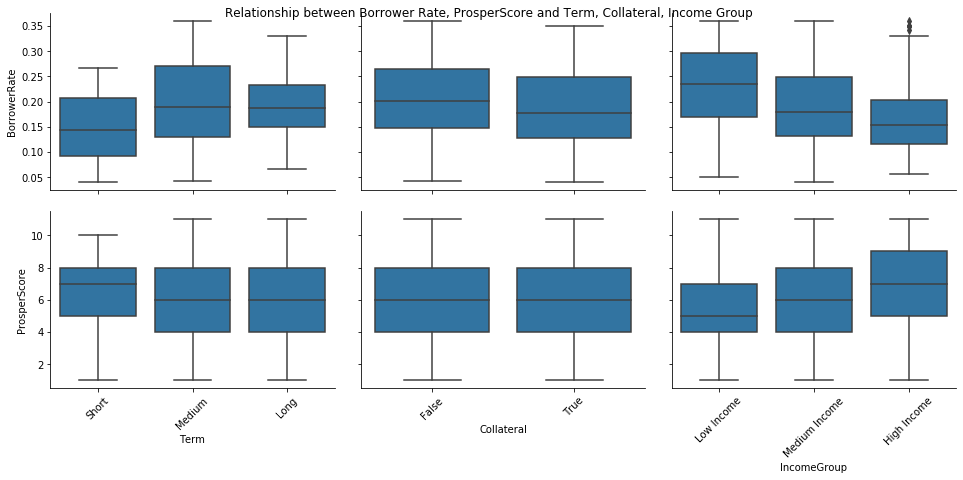

In [46]:
# plot matrix of numeric features against categorical/ordinal features.

#define boxgrid function
def boxgrid(x, y, **kwargs):
    sb.boxplot(x, y, color = base_color)
    plt.xticks(rotation=45);

g = sb.PairGrid(data = loan_df, y_vars = ['BorrowerRate', 'ProsperScore'], 
                x_vars = ['Term', 'Collateral', 'IncomeGroup'],height = 3, aspect = 1.5)
g.map(boxgrid)
plt.suptitle('Relationship between Borrower Rate, ProsperScore and Term, Collateral, Income Group');

## Relationship between Borrower Rate, ProsperScore and EmploymentStatus, IncomeRange
> Just as predicted, the Unemployed and those with less than 25,000 dollars have more restrictive credit condition (higher rate) than the people who are employed or have more 25,000 dollars and above.
> Meanwhile, being employed and having a income range above 25,000 dollars is proportional to having a high prosper score.

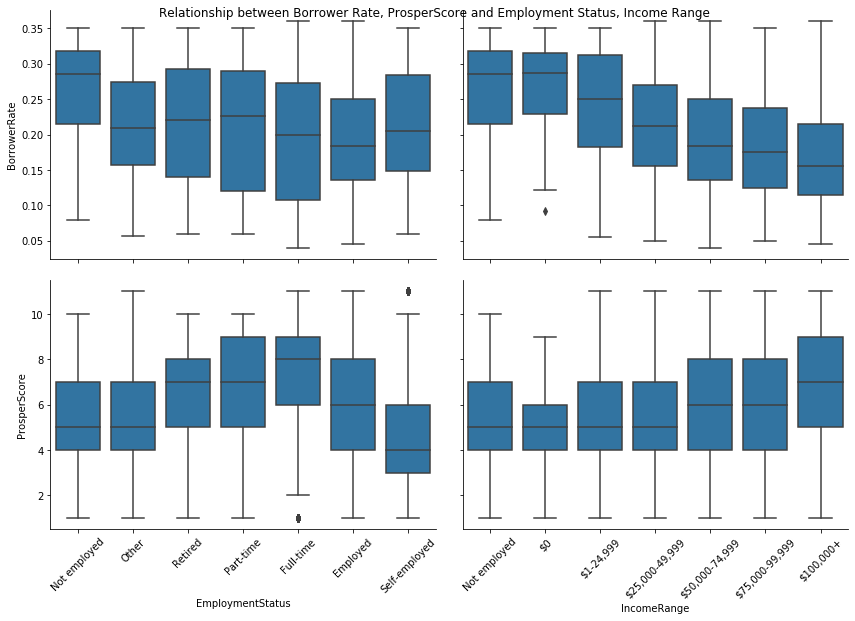

In [49]:
g = sb.PairGrid(data = loan_df, y_vars = ['BorrowerRate', 'ProsperScore'], 
                x_vars = ['EmploymentStatus', 'IncomeRange'],height = 4, aspect = 1.5)
g.map(boxgrid)
plt.suptitle('Relationship between Borrower Rate, ProsperScore and Employment Status, Income Range');

## Relationship between Borrower Rate and ProsperScore, ProsperRating, LoanStatus
>- The borrowers rate is inversely proportional to Prospers Score and Rating at any given time (the higher the score or rating, the lower the interest rate)
>- We can conclude that the Prosper score and Prosper Rating are the two most excellent determinant factor of borrower's rate.
>- Borrowers with AA prosper ratings could expect an APR that will likely fall into the 2-20% range, whereas borrowers with bad ratings (HR) could expect their interest rate to go as high as 38%!
>- Borrowers with poor loan status (Defaulted, ChargedOff and Past Due) have a higher interest rates as a result.

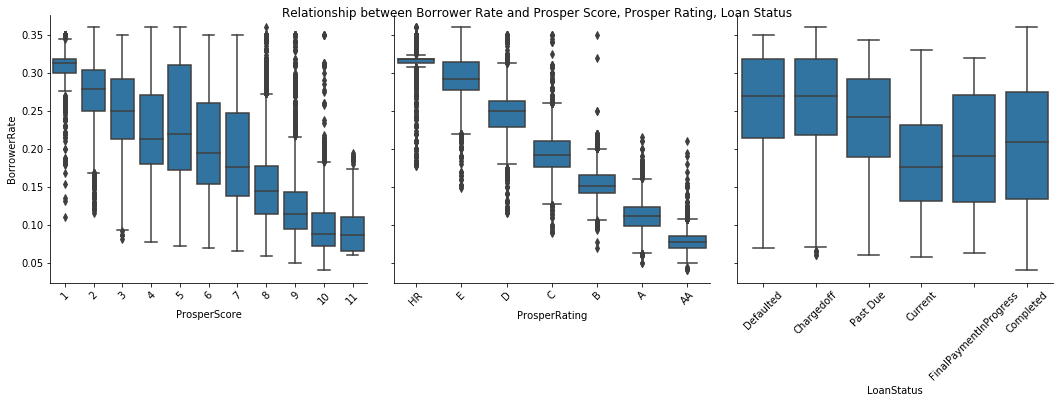

In [50]:
#plot multiple figures with Violin plot   
g = sb.PairGrid(data = loan_df, y_vars = ['BorrowerRate'], x_vars = ['ProsperScore','ProsperRating', 'LoanStatus'],
                height = 4.5, aspect = 1.1)

g.map(boxgrid)
plt.suptitle('Relationship between Borrower Rate and Prosper Score, Prosper Rating, Loan Status');

## Relationship between Borrower APR (Annual Cost), Original Loan Amount and some categorical variables
> Interestingly, it appears that there are some negative relationships between the categorical variables and the two numeric variables of interest. The customers with high prosper score, who are employed, has collateral and has the best Prosper Ratings seems to have a high loan original amount and consequently a lower borrowing rate.

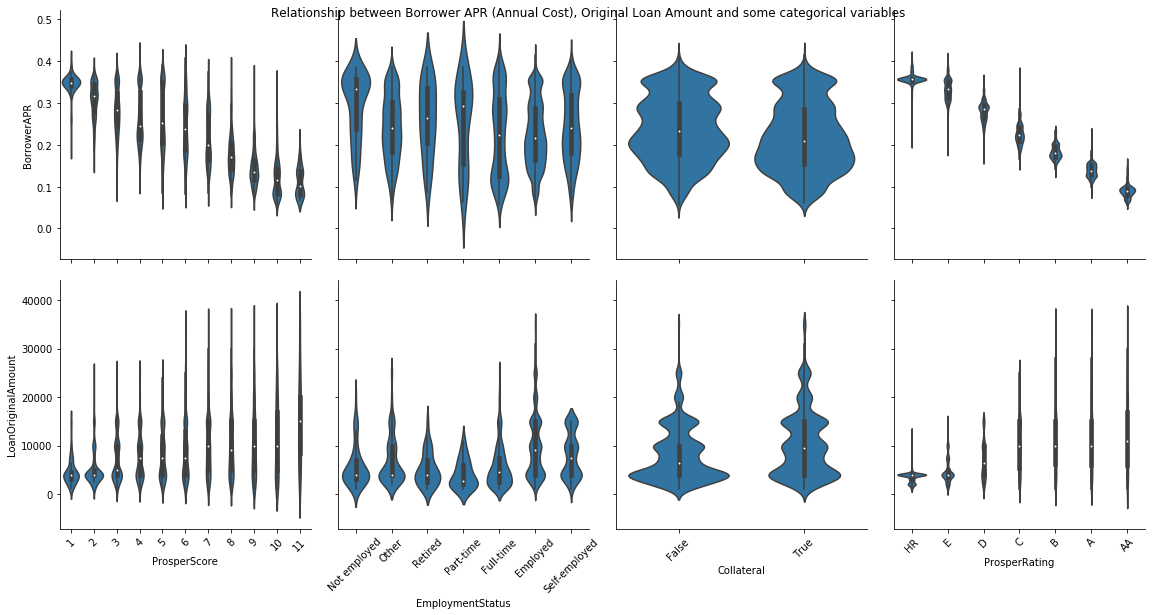

In [52]:
#define violin function
def violin(x, y, **kwargs):
    sb.violinplot(x, y, color = base_color)
    plt.xticks(rotation=45);
loan_df_samp = loan_df.sample(n=8000, replace=False)
#plot multiple figures with Pairgrid
g = sb.PairGrid(data = loan_df_samp, y_vars = ['BorrowerAPR', 'LoanOriginalAmount'], 
                x_vars = ['ProsperScore','EmploymentStatus','Collateral', 'ProsperRating'], 
                height = 4)
g.map(violin)
plt.suptitle('Relationship between Borrower APR (Annual Cost), Original Loan Amount and some categorical variables')
plt.show();

## Evolution of BorrowerRate, Investors over years for Homeowners & Non-Homeowners
> As we can see, the two rates and investors have almost the same evolution profile. 
>- As expected, rates for individuals with collateral(homeowner) are lower than those without collateral but the gap between the rate has decreased significantly since 2011. Also and investors tend to invest more with borrowers with collateral. Meanwhile, there has been a continuous decline in the number of investors in the loan requests of borrowers (regardless of their collateral) except for a slight stability between 2011 and 2012. 

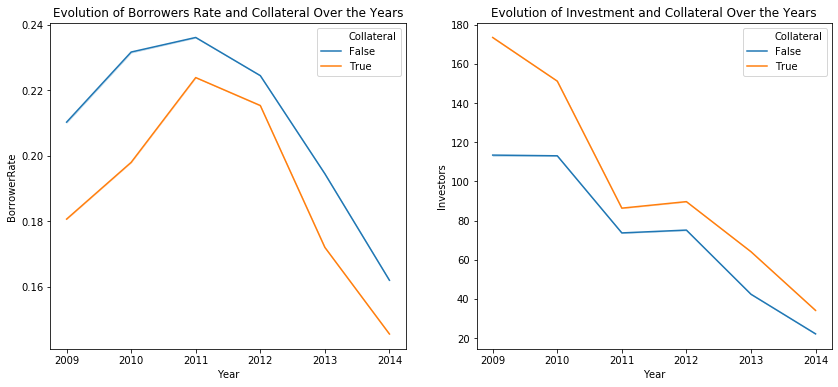

<Figure size 576x504 with 0 Axes>

In [53]:
fig, ax = plt.subplots(ncols = 2, figsize = [14,6])
# plot the lineplot to analyze homeowner's and non-homeowner's rate over the years
plt.figure(figsize=(8,7))
g=sb.lineplot(data=loan_df, x='Year', y='BorrowerRate', hue='Collateral',ci=True, ax = ax[0])
ax[0].set_title('Evolution of Borrowers Rate and Collateral Over the Years')

# plot the lineplot to analyze trend of investment in homeowner's and non-homeowner's loans over the years
g=sb.lineplot(data=loan_df, x='Year', y='Investors', hue='Collateral',ci=True, ax = ax[1])
ax[1].set_title('Evolution of Investment and Collateral Over the Years');

## Borrower Rate by Prosper rating and Income Group
> We can see that the rates applied on low income are generally higher than the rates applied on other wage groups, regardless of the prosper rating (with the exception of the AA rating (almost same rates for the three wage groups) and D and HR rating (same rates for low and medium wages), all other ratings supports our intial assumption. This is obvious, when the income is lower it increases the risk of this operation involving a rise in rates. Of course, as I already mentioned, the rates are the lowest for individuals with a good rating, this is also considered.

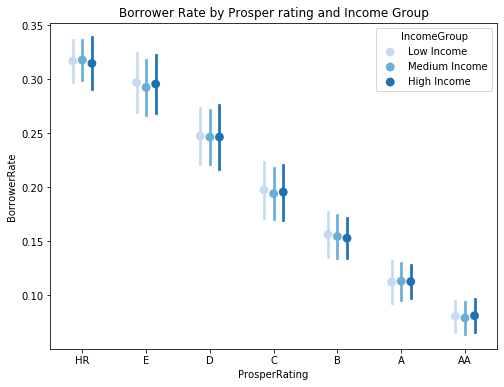

In [54]:
#plot pointplot 
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = loan_df, x = 'ProsperRating', y = 'BorrowerRate', hue='IncomeGroup',
                 palette='Blues', linestyles = '', dodge = 0.3, ci='sd', color=base_color)
plt.title('Borrower Rate by Prosper rating and Income Group');

## Borrower APR by Prosper Rating and Loan Status
> For all Prosper Ratings except for "A",and "AA", Defaulted and charged off loans usually have a higher Borrower APR compared to completed, payment in progress or current loans(good records).
> Generally, the negative correlation between ProsperRating and BorrowerAPR is explicitly shown here, those with good rating have a lower rate vise versa.

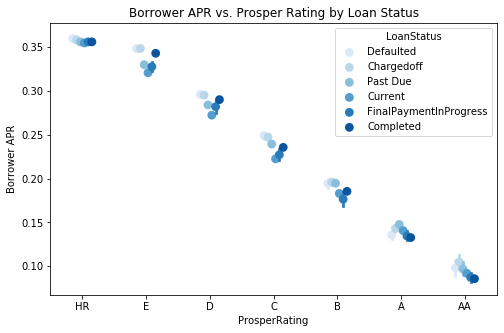

In [55]:
fig = plt.figure(figsize = [8,5])
#plot pointplot 
ax = sb.pointplot(data = loan_df, x = 'ProsperRating', y = 'BorrowerAPR', hue = 'LoanStatus',
           palette = 'Blues', linestyles = '', dodge = 0.3)
plt.title('Borrower APR vs. Prosper Rating by Loan Status')
plt.ylabel('Borrower APR')
plt.show();

## Loan Amount by Collateral and Income Group
> As shown in this visual, having a collateral and a higher wage help getting higher loan amount. It is clearly visible that being a home owner is a very important element to getting a higher loan amount.

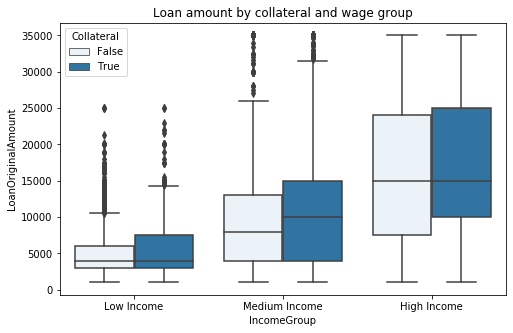

In [56]:
#plot boxplot
plt.figure(figsize = [8,5])
sb.boxplot(data = loan_df, x = 'IncomeGroup', y = 'LoanOriginalAmount',
           hue = 'Collateral' ,color = base_color)
plt.title('Loan amount by collateral and wage group');

### Generate Slideshow
Run the command below to generate the HTML slideshow.

In [2]:
# The command below will generate the HTML slideshow. 
!jupyter nbconvert Part_II_Prosper_Loan_Slide_Deck.ipynb --to slides --post serve --no-input --no-prompt 